# Spam Detection with LSTM and Attention

This notebook demonstrates the implementation of a neural network for detecting spam emails using LSTM and attention mechanisms. We will cover loading preprocessed data, defining the model architecture, training the model, and evaluating its performance.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
import json
from tensorflow.keras.preprocessing.text import tokenizer_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Custom Dataset Class
We define a custom Dataset class to load text data and labels.

In [1]:
# Custom Dataset class for loading data
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        return torch.tensor(text, dtype=torch.long), torch.tensor(label, dtype=torch.float)



### Neural Network Definition

The neural network consists of an embedding layer, an LSTM layer, an attention mechanism, and fully connected layers.

In [ ]:
# Define the neural network
class SpamDetector(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, max_sequence_length):
        super(SpamDetector, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.attention = nn.Linear(hidden_dim, 1)
        self.fc1 = nn.Linear(hidden_dim, 128)
        self.fc2 = nn.Linear(128, 1)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, x):
        embedded = self.embedding(x)  # Shape: (batch_size, seq_length, embedding_dim)
        lstm_out, _ = self.lstm(embedded)  # Shape: (batch_size, seq_length, hidden_dim)
        
        # Attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_out), dim=1)  # Shape: (batch_size, seq_length, 1)
        attention_output = torch.sum(attention_weights * lstm_out, dim=1)  # Shape: (batch_size, hidden_dim)
        
        x = self.dropout(attention_output)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))  # Apply sigmoid activation
        return x

### Evaluation Functions

We define functions to evaluate the F1 score and plot the confusion matrix.

In [ ]:
def evaluate_f1_score(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    f1 = f1_score(all_labels, all_preds, average='weighted')
    return f1

def plot_confusion_matrix(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for texts, labels in test_loader:
            outputs = model(texts)
            outputs = outputs.squeeze()  # Remove the extra dimension
            predicted = (outputs > 0.5).float()  # Apply threshold to convert probabilities to 0 or 1
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()



### Load Preprocessed Data

Load the preprocessed data from saved files

In [ ]:
# Load the saved data
X_train_padded = np.load('data/X_train_padded.npy')
X_test_padded = np.load('data/X_test_padded.npy')
y_train = np.load('data/y_train.npy')
y_test = np.load('data/y_test.npy')

### Model Parameters
Define the model parameters

In [ ]:
# Parameters
vocab_size = 5000  # Size of the vocabulary
embedding_dim = 500  # Embedding dimensions
hidden_dim = 128  # LSTM hidden dimensions
max_sequence_length = X_train_padded.shape[1]
batch_size = 500  # Batch size
epochs = 10  # Number of epochs

### Create DataLoader
Create DataLoader for training and testing datasets

In [ ]:
# Create DataLoader
train_dataset = TextDataset(X_train_padded, y_train)
test_dataset = TextDataset(X_test_padded, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Initialize Model, Loss Function, and Optimizer
Initialize the model, loss function, and optimizer.

In [ ]:
# Initialize model, loss function, and optimizer
model = SpamDetector(vocab_size, embedding_dim, hidden_dim, max_sequence_length)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training Loop
Train the model and print the loss for every print_every batches.

In [2]:
# Training loop 
print_every = 20  

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for i, (texts, labels) in enumerate(train_loader, 1):
        optimizer.zero_grad()
        outputs = model(texts)
        outputs = outputs.squeeze()  # Remove the extra dimension
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        # Print batch number
        if i % print_every == 0 or i == len(train_loader):
            print(f'Epoch {epoch+1}/{epochs}, Batch {i}/{len(train_loader)}, Loss: {loss.item()}')

    # Print epoch loss
    print(f'Epoch {epoch+1}/{epochs}, Average Loss: {running_loss/len(train_loader)}')

Epoch 1/10, Batch 9/9, Loss: 0.6142640709877014
Epoch 1/10, Average Loss: 0.6234778430726793
Epoch 2/10, Batch 9/9, Loss: 0.6405847072601318
Epoch 2/10, Average Loss: 0.6125979092386034
Epoch 3/10, Batch 9/9, Loss: 0.579770565032959
Epoch 3/10, Average Loss: 0.6078314185142517
Epoch 4/10, Batch 9/9, Loss: 0.5565627813339233
Epoch 4/10, Average Loss: 0.6008169452349345
Epoch 5/10, Batch 9/9, Loss: 0.5841623544692993
Epoch 5/10, Average Loss: 0.5887506670422025
Epoch 6/10, Batch 9/9, Loss: 0.3911881744861603
Epoch 6/10, Average Loss: 0.4657502207491133
Epoch 7/10, Batch 9/9, Loss: 0.32561856508255005
Epoch 7/10, Average Loss: 0.2889922128783332
Epoch 8/10, Batch 9/9, Loss: 0.1362244039773941
Epoch 8/10, Average Loss: 0.16773906681272718
Epoch 9/10, Batch 9/9, Loss: 0.034969329833984375
Epoch 9/10, Average Loss: 0.09925294667482376
Epoch 10/10, Batch 9/9, Loss: 0.12261643260717392
Epoch 10/10, Average Loss: 0.07450298344095548


### Evaluate Model
Evaluate the model using the F1 score and plot the confusion matrix

Test F1 Score: 0.5987


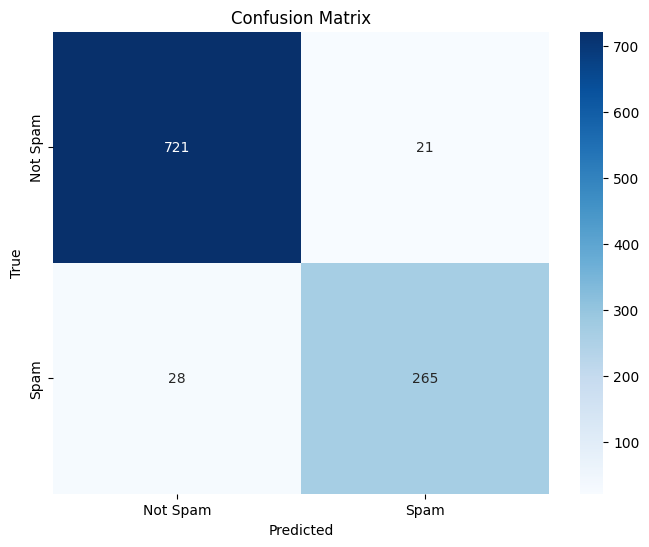

In [7]:
# Evaluate F1 Score
f1 = evaluate_f1_score(model, test_loader)
print(f'Test F1 Score: {f1:.4f}')

# Plot Confusion Matrix
plot_confusion_matrix(model, test_loader)

This notebook demonstrates the complete process of defining, training, and evaluating a neural network for spam detection using LSTM and attention mechanisms. The model is evaluated using the F1 score and confusion matrix to measure its performance.
